# ATIS - Intent and Slot

In [1]:
import json
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter
import pickle
%matplotlib inline

In [2]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [3]:

def prepare_sequence(seq, to_ix):
    idxs = list(map(lambda w: to_ix[w] if w in to_ix.keys() else to_ix["<UNK>"], seq))
    tensor = Variable(torch.LongTensor(idxs)).cuda() if USE_CUDA else Variable(torch.LongTensor(idxs))
    return tensor


flatten = lambda l: [item for sublist in l for item in sublist]

In [4]:
train = open("/home/himanshubeniwal/acm_ss/RNN-for-Joint-NLU/atis-2.train.w-intent.iob","r").readlines()
train = [t[:-1] for t in train]
train = [[t.split("\t")[0].split(" "),t.split("\t")[1].split(" ")[:-1],t.split("\t")[1].split(" ")[-1]] for t in train]
train = [[t[0][1:-1],t[1][1:],t[2]] for t in train]

In [5]:
print(train[1])

[['round', 'trip', 'fares', 'from', 'baltimore', 'to', 'philadelphia', 'less', 'than', '1000', 'dollars', 'round', 'trip', 'fares', 'from', 'denver', 'to', 'philadelphia', 'less', 'than', '1000', 'dollars', 'round', 'trip', 'fares', 'from', 'pittsburgh', 'to', 'philadelphia', 'less', 'than', '1000', 'dollars'], ['B-round_trip', 'I-round_trip', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'B-cost_relative', 'O', 'B-fare_amount', 'I-fare_amount', 'B-round_trip', 'I-round_trip', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'B-cost_relative', 'O', 'B-fare_amount', 'I-fare_amount', 'B-round_trip', 'I-round_trip', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'B-cost_relative', 'O', 'B-fare_amount', 'I-fare_amount'], 'atis_airfare']


## Dataset classes

In [6]:
all_classes = []
for i in train:
    print(i[2]) # Will print all the classes.
    all_classes.append(i[2])

atis_flight
atis_airfare
atis_flight
atis_flight
atis_airline
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight
atis_ground_service
atis_flight
atis_flight
atis_flight
atis_quantity
atis_flight
atis_airfare
atis_quantity
atis_flight
atis_flight
atis_flight
atis_city
atis_ground_service
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight#atis_airfare
atis_abbreviation
atis_ground_service
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight
atis_airfare
atis_flight
atis_airfare
atis_flight
atis_flight
atis_flight
atis_abbreviation
atis_flight
atis_airline
atis_ground_service
atis_flight
atis_flight
atis_flight
atis_aircraft
atis_flight
atis_airline
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight
atis_airfare
atis_airline
atis_flight
atis_flight
atis_airfare
atis_flight
atis_flight
atis_abbreviation
atis_flight
atis_flight
atis_flight
atis_flight
atis_flight

In [7]:
import pandas as pd
df_classes = pd.DataFrame(all_classes)

In [8]:
df_classes

,0
0,atis_flight
1,atis_airfare
2,atis_flight
3,atis_flight
4,atis_airline
...,...
4473,atis_flight
4474,atis_flight
4475,atis_ground_service
4476,atis_flight


In [9]:
from collections import Counter
all_classes_count = Counter(all_classes)
print(all_classes_count)

Counter({'atis_flight': 3308, 'atis_airfare': 385, 'atis_ground_service': 230, 'atis_airline': 139, 'atis_abbreviation': 130, 'atis_aircraft': 70, 'atis_flight_time': 45, 'atis_quantity': 41, 'atis_flight#atis_airfare': 19, 'atis_city': 18, 'atis_distance': 17, 'atis_airport': 17, 'atis_ground_fare': 15, 'atis_capacity': 15, 'atis_flight_no': 12, 'atis_meal': 6, 'atis_restriction': 5, 'atis_airline#atis_flight_no': 2, 'atis_aircraft#atis_flight#atis_flight_no': 1, 'atis_cheapest': 1, 'atis_ground_service#atis_ground_fare': 1, 'atis_fligh': 1})


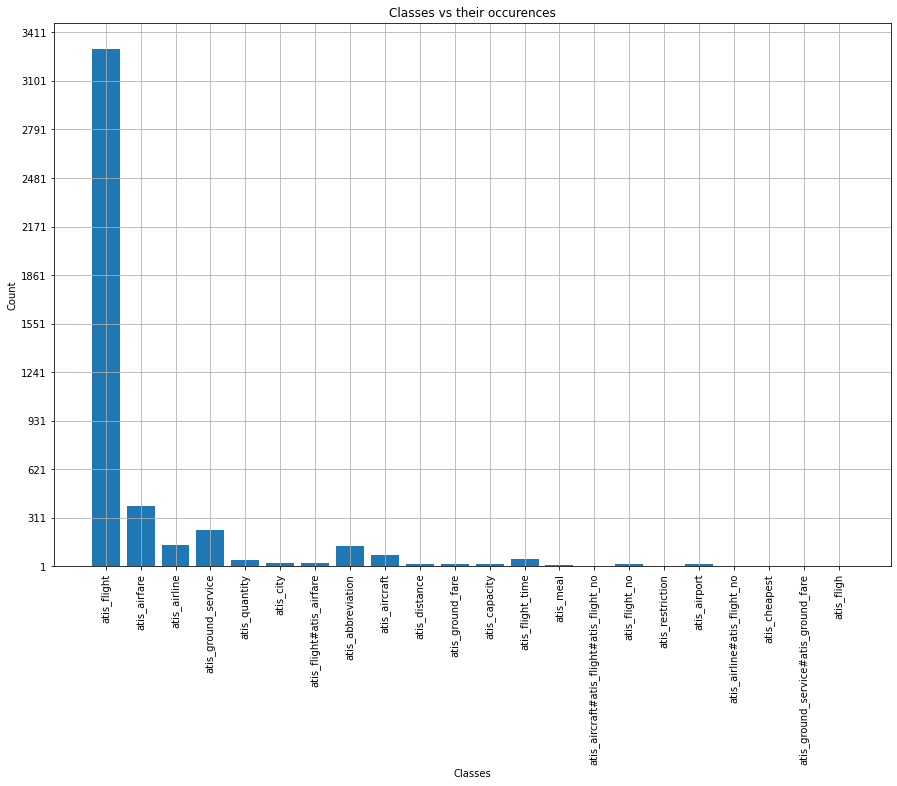

In [10]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.bar(all_classes_count.keys(), all_classes_count.values())
plt.xticks(rotation=90)
plt.grid('on')

plt.xlabel('Classes')
plt.ylabel('Count')
plt.yticks(np.arange(min(all_classes_count.values()), max( all_classes_count.values())+200, 310.0) )
plt.title('Classes vs their occurences')

plt.show()

## Dataset rendering through Spacy

In [11]:
all_text = []
for i in train:
    # print(i[0]) # Will print all the classes.
    tex = " ".join(i[0])
    # print(tex)
    all_text.append(tex)

In [12]:
all_text

['i want to fly from baltimore to dallas round trip',
 'round trip fares from baltimore to philadelphia less than 1000 dollars round trip fares from denver to philadelphia less than 1000 dollars round trip fares from pittsburgh to philadelphia less than 1000 dollars',
 'show me the flights arriving on baltimore on june fourteenth',
 'what are the flights which depart from san francisco fly to washington via indianapolis and arrive by 9 pm',
 'which airlines fly from boston to washington dc via other cities',
 "i'm looking for a flight from charlotte to las vegas that stops in st. louis hopefully a dinner flight how can i find that out",
 "okay and then from pittsburgh i'd like to travel to atlanta on september fourth",
 'show me all the flights from philadelphia to cincinnati',
 "okay i'd like a flight on us air from indianapolis to san diego in the afternoon what's available",
 'on tuesday what flights leave phoenix to st. paul minnesota and leave after noon',
 'american flights from 

In [13]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [14]:
Spacy_Text = all_text[1]
doc = nlp(Spacy_Text)
displacy.serve(doc, style="ent")

/home/himanshubeniwal/anaconda3/lib/python3.8/site-packages/spacy/displacy/__init__.py:103: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [15]:
Spacy_Text = " ".join(all_text)
doc = nlp(Spacy_Text)

In [16]:
len(doc.ents)

9877

In [17]:
labels = [ent.label_ for ent in doc.ents]
spacy_labels = Counter(labels)
spacy_labels

Counter({'GPE': 7116,
         'MONEY': 39,
         'DATE': 1059,
         'TIME': 767,
         'PERSON': 52,
         'NORP': 58,
         'ORG': 280,
         'ORDINAL': 173,
         'CARDINAL': 255,
         'FAC': 30,
         'QUANTITY': 12,
         'EVENT': 8,
         'PRODUCT': 15,
         'LOC': 13})

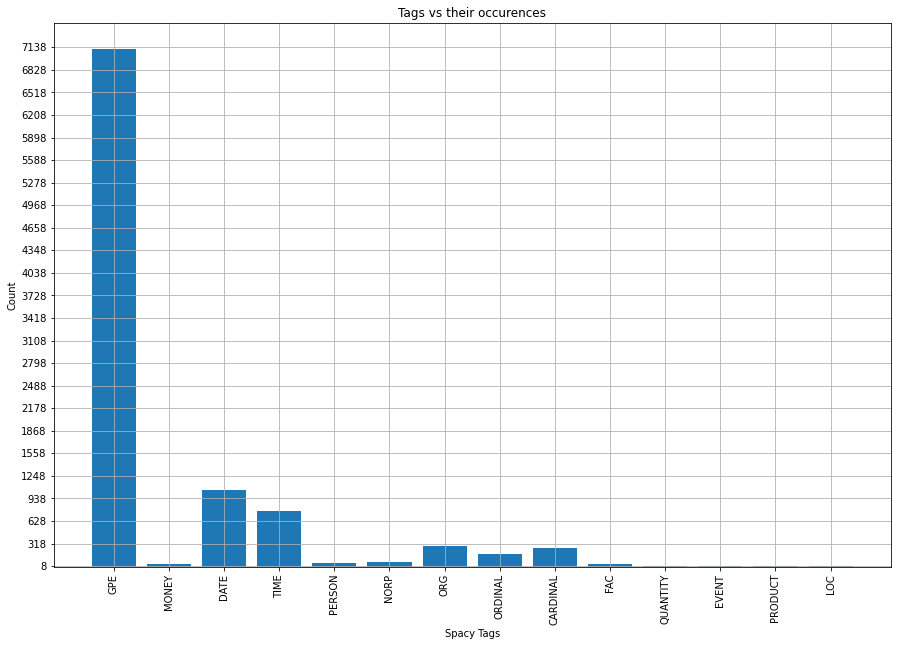

In [18]:
plt.bar(spacy_labels.keys(), spacy_labels.values())
plt.xticks(rotation=90)
plt.grid('on')
plt.yticks(np.arange(min(spacy_labels.values()), max( spacy_labels.values())+200, 310.0) )
plt.xlabel('Spacy Tags')
plt.ylabel('Count')
plt.title('Tags vs their occurences')
plt.show()